In [1]:
#Importing the modules and packages
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
def load_doc(filename):
    
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    return text

filename = "Flickr8k_text/Flickr8k.token.txt"

#Loading the document
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [4]:

def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        
        tokens = line.split()
        if len(line) < 2:
            continue
        
        #Extract the names from the descriptions
        image_id, image_desc = tokens[0], tokens[1:]        
        image_id = image_id.split('.')[0]        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

#Load all descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
def clean_descriptions(descriptions):
    
    #Define punctuations
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            #Filter and convert to lower case, remove puncuations
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if word.isalpha()]

            desc_list[i] =  ' '.join(desc)

#Clean the descriptions
clean_descriptions(descriptions)

In [8]:
#Convert descriptions in Vocabulary
def to_vocabulary(descriptions):

    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

#Make a function Call
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [9]:
#Save the Descriptions to disk
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

#Make the function call
save_descriptions(descriptions, 'Descriptions.txt')

In [10]:
#Load pics list
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
            
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

#Define the path and make the Function call
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [14]:
#Define and generate path names for all images
images = 'Flickr8k_Dataset/'
img = glob.glob(images + '*.jpg')

In [16]:
img

['Flickr8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flickr8k_Dataset\\1003163366_44323f5815.jpg',
 'Flickr8k_Dataset\\1007129816_e794419615.jpg',
 'Flickr8k_Dataset\\1007320043_627395c3d8.jpg',
 'Flickr8k_Dataset\\1009434119_febe49276a.jpg',
 'Flickr8k_Dataset\\1012212859_01547e3f17.jpg',
 'Flickr8k_Dataset\\1015118661_980735411b.jpg',
 'Flickr8k_Dataset\\1015584366_dfcec3c85a.jpg',
 'Flickr8k_Dataset\\101654506_8eb26cfb60.jpg',
 'Flickr8k_Dataset\\101669240_b2d3e7f17b.jpg',
 'Flickr8k_Dataset\\1016887272_03199f49c4.jpg',
 'Flickr8k_Dataset\\1019077836_6fc9b15408.jpg',
 'Flickr8k_Dataset\\1019604187_d087bf9a5f.jpg',
 'Flickr8k_Dataset\\1020651753_06077ec457.jpg',
 'Flickr8k_Dataset\\1022454332_6af2c1449a.jpg',
 'Flickr8k_Dataset\\1022454428_b6b660a67b.jpg',
 'Flickr8k_Dataset\\1022975728_75515238d8.jpg',
 'Flickr8k_Dataset\\102351840_323e3de834.jpg',
 'Flickr8k_Dataset\\1024138940_f1fefbdce1.j

In [17]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

#Read all training images
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

#Collect the full paths
train_img = []
for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [18]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'

#Read all testing images
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

#Collect the full paths
test_img = []

for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 

In [19]:
train_img

['Flickr8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flickr8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flickr8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flickr8k_Dataset\\1003163366_44323f5815.jpg',
 'Flickr8k_Dataset\\1007129816_e794419615.jpg',
 'Flickr8k_Dataset\\1007320043_627395c3d8.jpg',
 'Flickr8k_Dataset\\1009434119_febe49276a.jpg',
 'Flickr8k_Dataset\\1012212859_01547e3f17.jpg',
 'Flickr8k_Dataset\\1015118661_980735411b.jpg',
 'Flickr8k_Dataset\\1015584366_dfcec3c85a.jpg',
 'Flickr8k_Dataset\\101654506_8eb26cfb60.jpg',
 'Flickr8k_Dataset\\101669240_b2d3e7f17b.jpg',
 'Flickr8k_Dataset\\1016887272_03199f49c4.jpg',
 'Flickr8k_Dataset\\1019077836_6fc9b15408.jpg',
 'Flickr8k_Dataset\\1019604187_d087bf9a5f.jpg',
 'Flickr8k_Dataset\\1020651753_06077ec457.jpg',
 'Flickr8k_Dataset\\1022454428_b6b660a67b.jpg',
 'Flickr8k_Dataset\\1022975728_75515238d8.jpg',
 'Flickr8k_Dataset\\102351840_323e3de834.jpg',
 'Flickr8k_Dataset\\1024138940_f1fefbdce1.jpg',
 'Flickr8k_Dataset\\102455176_5f8ead62d5.jp

In [20]:
test_img

['Flickr8k_Dataset\\1056338697_4f7d7ce270.jpg',
 'Flickr8k_Dataset\\106490881_5a2dd9b7bd.jpg',
 'Flickr8k_Dataset\\1082379191_ec1e53f996.jpg',
 'Flickr8k_Dataset\\1084040636_97d9633581.jpg',
 'Flickr8k_Dataset\\1096395242_fc69f0ae5a.jpg',
 'Flickr8k_Dataset\\1107246521_d16a476380.jpg',
 'Flickr8k_Dataset\\1119015538_e8e796281e.jpg',
 'Flickr8k_Dataset\\1122944218_8eb3607403.jpg',
 'Flickr8k_Dataset\\1131800850_89c7ffd477.jpg',
 'Flickr8k_Dataset\\1131932671_c8d17751b3.jpg',
 'Flickr8k_Dataset\\113678030_87a6a6e42e.jpg',
 'Flickr8k_Dataset\\114051287_dd85625a04.jpg',
 'Flickr8k_Dataset\\115684808_cb01227802.jpg',
 'Flickr8k_Dataset\\1167669558_87a8a467d6.jpg',
 'Flickr8k_Dataset\\1174525839_7c1e6cfa86.jpg',
 'Flickr8k_Dataset\\1174629344_a2e1a2bdbf.jpg',
 'Flickr8k_Dataset\\1220401002_3f44b1f3f7.jpg',
 'Flickr8k_Dataset\\1224851143_33bcdd299c.jpg',
 'Flickr8k_Dataset\\1237985362_dbafc59280.jpg',
 'Flickr8k_Dataset\\1248940539_46d33ed487.jpg',
 'Flickr8k_Dataset\\1258913059_07c613f7ff.jp

In [21]:
#Load the descriptions for training
def load_clean_descriptions(filename, dataset):

    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]

        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()

            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

#Make the function call
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [22]:
#Image preprocessing
def preprocess(image_path):
    #Load with Target of 299,299 as per Inception Model
    img = image.load_img(image_path, target_size=(299, 299))    
    x = image.img_to_array(img)    
    x = np.expand_dims(x, axis=0)    
    x = preprocess_input(x)
    
    return x

In [23]:
#Load the pretrained model
model = InceptionV3(weights='imagenet')

In [24]:
#Unhook the last two layers
model_new = Model(model.input, model.layers[-2].output)

In [25]:
#Model Summary
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [26]:
#Extract features from images
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    
    #Reshape from (1, 2048) to (2048, )
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) 
    
    return fea_vec

In [27]:
#Make the function call and batch process on all training images
start = time()
encoding_train = {}

for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
    
print("Time taken in seconds =", time()-start)

Time taken in seconds = 2165.3559136390686


In [29]:
import pickle

In [30]:
#Save it to disk
with open("Encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [31]:
#Make the function call and batch process on all testing images
start = time()
encoding_test = {}

for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
    
print("Time taken in seconds =", time()-start)

Time taken in seconds = 373.04269194602966


In [32]:
#Save it to disk
with open("Encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [33]:
#Load the training features
train_features = load(open("Encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [34]:
#Generate all the training captions
all_train_captions = []

for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

30000

In [35]:
#Preprocess the word and build the vocabulary
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [36]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [37]:
vocab_size = len(ixtoword) + 1 
vocab_size

1652

In [38]:
#Dictionary to list -> Descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

#Max length of Descriptions
def max_length(descriptions):
    lines = to_lines(descriptions)
    
    return max(len(d.split()) for d in lines)

#Max sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [39]:
#Function to load the data in batches
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    #Main loop for iterating over the images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            
            #Get pic feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                
                #Encoding the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                #Splitting into pairs
                for i in range(1, len(seq)):
                    #Giving Input Sequence and Output Sequence
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    #Padding the sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    #Output Sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            #Batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [40]:
#Load the word emebeddings
glove_dir = 'glove.6B'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [41]:
embedding_dim = 200

#Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():    
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:        
        embedding_matrix[i] = embedding_vector

In [42]:
embedding_matrix.shape

(1652, 200)

In [43]:
#Define the Encoder-Decoder Architecture
#Parallel 1
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

#Parallel 2
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

#Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

#Build the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [44]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [45]:
model.layers[2]

In [46]:
#Setting weight of Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [47]:
#Compiling the model using Adam Optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [50]:
#Defining model hyperparameters
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [52]:
#Training the model
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1058s 529ms/step - loss: 3.4193
Epoch 1/1
2000/2000 [==============================] - 1018s 509ms/step - loss: 3.1977
Epoch 1/1
2000/2000 [==============================] - 995s 497ms/step - loss: 3.0622
Epoch 1/1
2000/2000 [==============================] - 997s 498ms/step - loss: 2.9665
Epoch 1/1
2000/2000 [==============================] - 1031s 516ms/step - loss: 2.8919
Epoch 1/1
2000/2000 [==============================] - 1084s 542ms/step - loss: 2.8336
Epoch 1/1
2000/2000 [==============================] - 1135s 567ms/step - loss: 2.7812
Epoch 1/1
2000/2000 [==============================] - 1031s 516ms/step - loss: 2.7426
Epoch 1/1
2000/2000 [==============================] - 1010s 505ms/step - loss: 2.7059
Epoch 1/1
2000/2000 [==============================] - 1000s 500ms/step - loss: 2.6750


In [53]:
#Training the model
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1098s 549ms/step - loss: 2.6505
Epoch 1/1
2000/2000 [==============================] - 998s 499ms/step - loss: 2.6230
Epoch 1/1
2000/2000 [==============================] - 998s 499ms/step - loss: 2.6049
Epoch 1/1
2000/2000 [==============================] - 1000s 500ms/step - loss: 2.5822
Epoch 1/1
2000/2000 [==============================] - 1002s 501ms/step - loss: 2.5687
Epoch 1/1
2000/2000 [==============================] - 997s 499ms/step - loss: 2.5520
Epoch 1/1
2000/2000 [==============================] - 999s 500ms/step - loss: 2.5349
Epoch 1/1
2000/2000 [==============================] - 1008s 504ms/step - loss: 2.5256
Epoch 1/1
2000/2000 [==============================] - 1004s 502ms/step - loss: 2.5128
Epoch 1/1
2000/2000 [==============================] - 1033s 516ms/step - loss: 2.5009


In [56]:
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [57]:
#Training the model
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 1017s 1s/step - loss: 2.4527
Epoch 1/1
1000/1000 [==============================] - 1064s 1s/step - loss: 2.4338
Epoch 1/1
1000/1000 [==============================] - 1036s 1s/step - loss: 2.4241
Epoch 1/1
1000/1000 [==============================] - 1040s 1s/step - loss: 2.4111
Epoch 1/1
1000/1000 [==============================] - 1040s 1s/step - loss: 2.4035
Epoch 1/1
1000/1000 [==============================] - 1053s 1s/step - loss: 2.3933
Epoch 1/1
1000/1000 [==============================] - 1050s 1s/step - loss: 2.3838
Epoch 1/1
1000/1000 [==============================] - 968s 968ms/step - loss: 2.3735
Epoch 1/1
1000/1000 [==============================] - 964s 964ms/step - loss: 2.3681
Epoch 1/1
1000/1000 [==============================] - 1093s 1s/step - loss: 2.3608


In [59]:
#Save the model weights
model.save_weights('model_30.h5')

In [60]:
#Save the complete model with configurations
model.save('ImageCaptionGenerator.h5')

In [61]:
#Load the test image features
with open("Encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [62]:
#Function to generate caption
def GenerateCaption(photo):
    #In sequence
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        #Make predictions
        y = model.predict([photo,sequence], verbose=0)
        y = np.argmax(y)
        word = ixtoword[y]
        in_text += ' ' + word
        
        #If out sequence found
        if word == 'endseq':
            break
            
    #Clean the caption
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

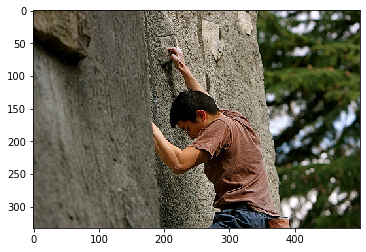

Caption: boy in red shirt is climbing up rock wall


In [95]:
#Call the function with an image features vector passed as argument
z+=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", GenerateCaption(image))

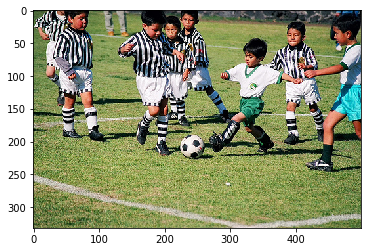

Caption: two boys play soccer on field


In [96]:
z+=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", GenerateCaption(image))

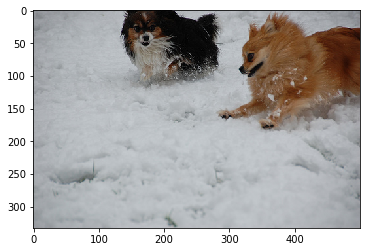

Caption: two dogs are fighting over piece of red ball in the snow


In [97]:
z+=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", GenerateCaption(image))

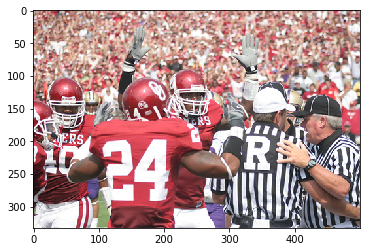

Caption: two american football players are competing


In [98]:
z+=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", GenerateCaption(image))

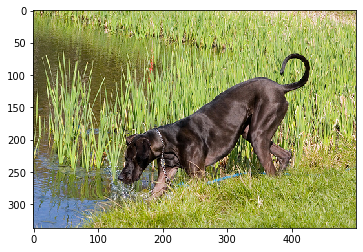

Caption: black dog is running through the grass


In [105]:
z+=5
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", GenerateCaption(image))